# Tutorial for running the CNN

This is a tutorial on running the CNN to generate the information plane graph mentioned. My CNN consists of a simple network containing 2 convolutional layers, 2 fully connected layers, and one dropout layer. I ran the CNN for 7 epochs due to hardware limitations. My system kept crashing whenever I tried to run it for more than 7 epochs owing to low memory. 

The CNN was added to IDNNs/idnns/networks/models.py where the exisitng models were already present. 

The program starts by running IDNNs/main.py

```
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


from idnns.networks import information_network as inet
def main():
    #Build the network
    print ('Building the network')
    net = inet.informationNetwork()
    net.print_information()

    print ('Start running the network')
    net.run_network()

    print ('Saving data')
    net.save_data()

    print ('Ploting figures')
    #Plot the newtork
    net.plot_network()
    
if __name__ == '__main__':
    main()

```

The first step is to initialize the network using the constructor present in networks/information_network.py

A sub-step in the initialization process is to load the data which is handled in networks/utils.py. Here, the CIFAR10 dataset is downloaded and loaded.

```
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("Shapes:")
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
x_train, x_test = x_train / 255.0, x_test / 255.0
data_sets.data = np.concatenate((x_train, x_test), axis=0).reshape((-1, 32*32*3))
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)
train_labels = np.eye(10, dtype='float32')[y_train]
test_labels = np.eye(10, dtype='float32')[y_test]
```

Once the network is initialized, the hyperparameters of the network are printed.

### Step 2: Running/Training the Network

The next step is to train the network. This is done by calling the run_network() function in main.py. This function is present in networks/information_networks.py

This function calls the train_and_calc_inf_network function which first begins the training process over the number of epochs using the batch size. 


Once the training is complete, the function proceeds to calculate the information by calling the get_information function present in information/information_process.py

This function calculates the information per epoch and returns it to the train_and_calc_inf_network function which stores it in a list for future use. 

```
for i in range(len(self.train_samples)):
	for j in range(len(self.layers_sizes)):
		for k in range(self.num_of_repeats):
			index = i * len(self.layers_sizes) * self.num_of_repeats + j * self.num_of_repeats + k
			current_network = results[index]
			self.networks[k][j][i] = current_network
			self.ws[k][j][i] = current_network['ws']
			self.weights[k][j][i] = current_network['weights']
			self.information[k][j][i] = current_network['information']
			self.grads[k][i][i] = current_network['gradients']
			self.test_error[k, j, i, :] = current_network['test_prediction']



			self.train_error[k, j, i, :] = current_network['train_prediction']
			self.loss_test[k, j, i, :] = current_network['loss_test']
			self.loss_train[k, j, i, :] = current_network['loss_train']
```

The functions used during this step are all the default functions that were given in the repo.

The structure of my CNN is the following:

```

# First convolutional layer - maps one grayscale image to 32 feature maps.
	with tf.name_scope('conv1'):
		with tf.name_scope('weights'):
			W_conv1 = weight_variable([5, 5, 3, 32])
			variable_summaries(W_conv1)
		with tf.name_scope('biases'):
			b_conv1 = bias_variable([32])
			variable_summaries(b_conv1)
		with tf.name_scope('activation'):
			input_con1 = conv2d(x_image, W_conv1) + b_conv1
			h_conv1 = tf.nn.relu(input_con1)
			tf.summary.histogram('activations', h_conv1)
		with tf.name_scope('max_pol'):
			# Pooling layer - downsamples by 2X.
			h_pool1 = max_pool_2x2(h_conv1)
		input.append(input_con1)
		hidden.append(h_pool1)
	with tf.name_scope('conv2'):
		# Second convolutional layer -- maps 32 feature maps to 64.
		with tf.name_scope('weights'):
			W_conv2 = weight_variable([5, 5, 32, 64])
			variable_summaries(W_conv2)
		with tf.name_scope('biases'):
			b_conv2 = bias_variable([64])
			variable_summaries(b_conv2)
		with tf.name_scope('activation'):
			input_con2 = conv2d(h_pool1, W_conv2) + b_conv2
			h_conv2 = tf.nn.relu(input_con2)
			tf.summary.histogram('activations', h_conv2)
		with tf.name_scope('max_pol'):
			# Second pooling layer.
			h_pool2 = max_pool_2x2(h_conv2)
		input.append(input_con2)
		hidden.append(h_pool2)
	# Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
	# is down to 7x7x64 feature maps -- maps this to 1024 features.
	with tf.name_scope('FC1'):
		with tf.name_scope('weights'):
			W_fc1 = weight_variable([8 * 8 * 64, 1024])
			variable_summaries(W_fc1)
		with tf.name_scope('biases'):
			b_fc1 = bias_variable([1024])
			variable_summaries(b_fc1)
		h_pool2_flat = tf.reshape(h_pool2, [-1, 8 * 8 * 64])
		with tf.name_scope('activation'):
			input_fc1 = tf.matmul(h_pool2_flat, W_fc1) + b_fc1
			h_fc1 = tf.nn.relu(input_fc1)
			tf.summary.histogram('activations', h_fc1)

	with tf.name_scope('drouput'):
		#keep_prob = tf.placeholder(tf.float32)
		keep_prob = 1.0
		tf.summary.scalar('dropout_keep_probability', keep_prob)
		h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
		input.append(input_fc1)
		hidden.append(h_fc1_drop)
	# Map the 1024 features to 10 classes, one for each digit
	with tf.name_scope('FC2'):
		with tf.name_scope('weights'):
			W_fc2 = weight_variable([1024, 10])
			variable_summaries(W_fc2)
		with tf.name_scope('biases'):
			b_fc2 = bias_variable([10])
			variable_summaries(b_fc2)

	input_y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
	y_conv = tf.nn.softmax(input_y_conv)
	input.append(input_y_conv)
	hidden.append(y_conv)
	return y_conv, keep_prob, hidden, input

```

### Step 3: Saving the Data

Once the network is trained and the necessary values are calculated and stored, main.py calls the save_data() function which is present in networks/information_networks.py

```
def save_data(self, parent_dir='jobs/', file_to_save='data.pickle'):
    """Save the data to the file """
    directory = '{0}/{1}{2}/'.format(os.getcwd(), parent_dir, self.params['directory'])

    data = {'information': self.information,
            'test_error': self.test_error, 'train_error': self.train_error, 'var_grad_val': self.grads,
            'loss_test': self.loss_test, 'loss_train': self.loss_train, 'params': self.params
        , 'l1_norms': self.l1_norms, 'weights': self.weights, 'ws': self.ws}

    if not os.path.exists(directory):
        os.makedirs(directory)
    self.dir_saved = directory
    with open(self.dir_saved + file_to_save, 'wb') as f:
        cPickle.dump(data, f, protocol=4)
```

This function gathers all the data and saves it as a pickle file in our jobs/ directory. 

One change I made here was change the pickle protocol from 2 to 4 to store larger pickle files as the data generated from training the CNN on CIFAR10 is enormous. 

Once the data is saved, we are ready to move on to the next step.

### Step 4: Plotting the Figures

The final step is to plot the information plane figure. This is done by calling the plot_network() function in networks/information_network.py

This leads us to the plot_figures() function present in plots/plot_figures.py.

plot_figures() uses the get_data() function to retreive data from the saved pickle file.

```
def get_data(name):
	"""Load data from the given name"""
	gen_data = {}
	# new version
	if os.path.isfile(name + 'data.pickle'):
		curent_f = open(name + 'data.pickle', 'rb')
		d2 = cPickle.load(curent_f)
	return d2
```



Once the data is retreived, we plot the data using plot_all_epochs() function present in plots/plot_figures.py

The information plane graph generated by my network is attached below

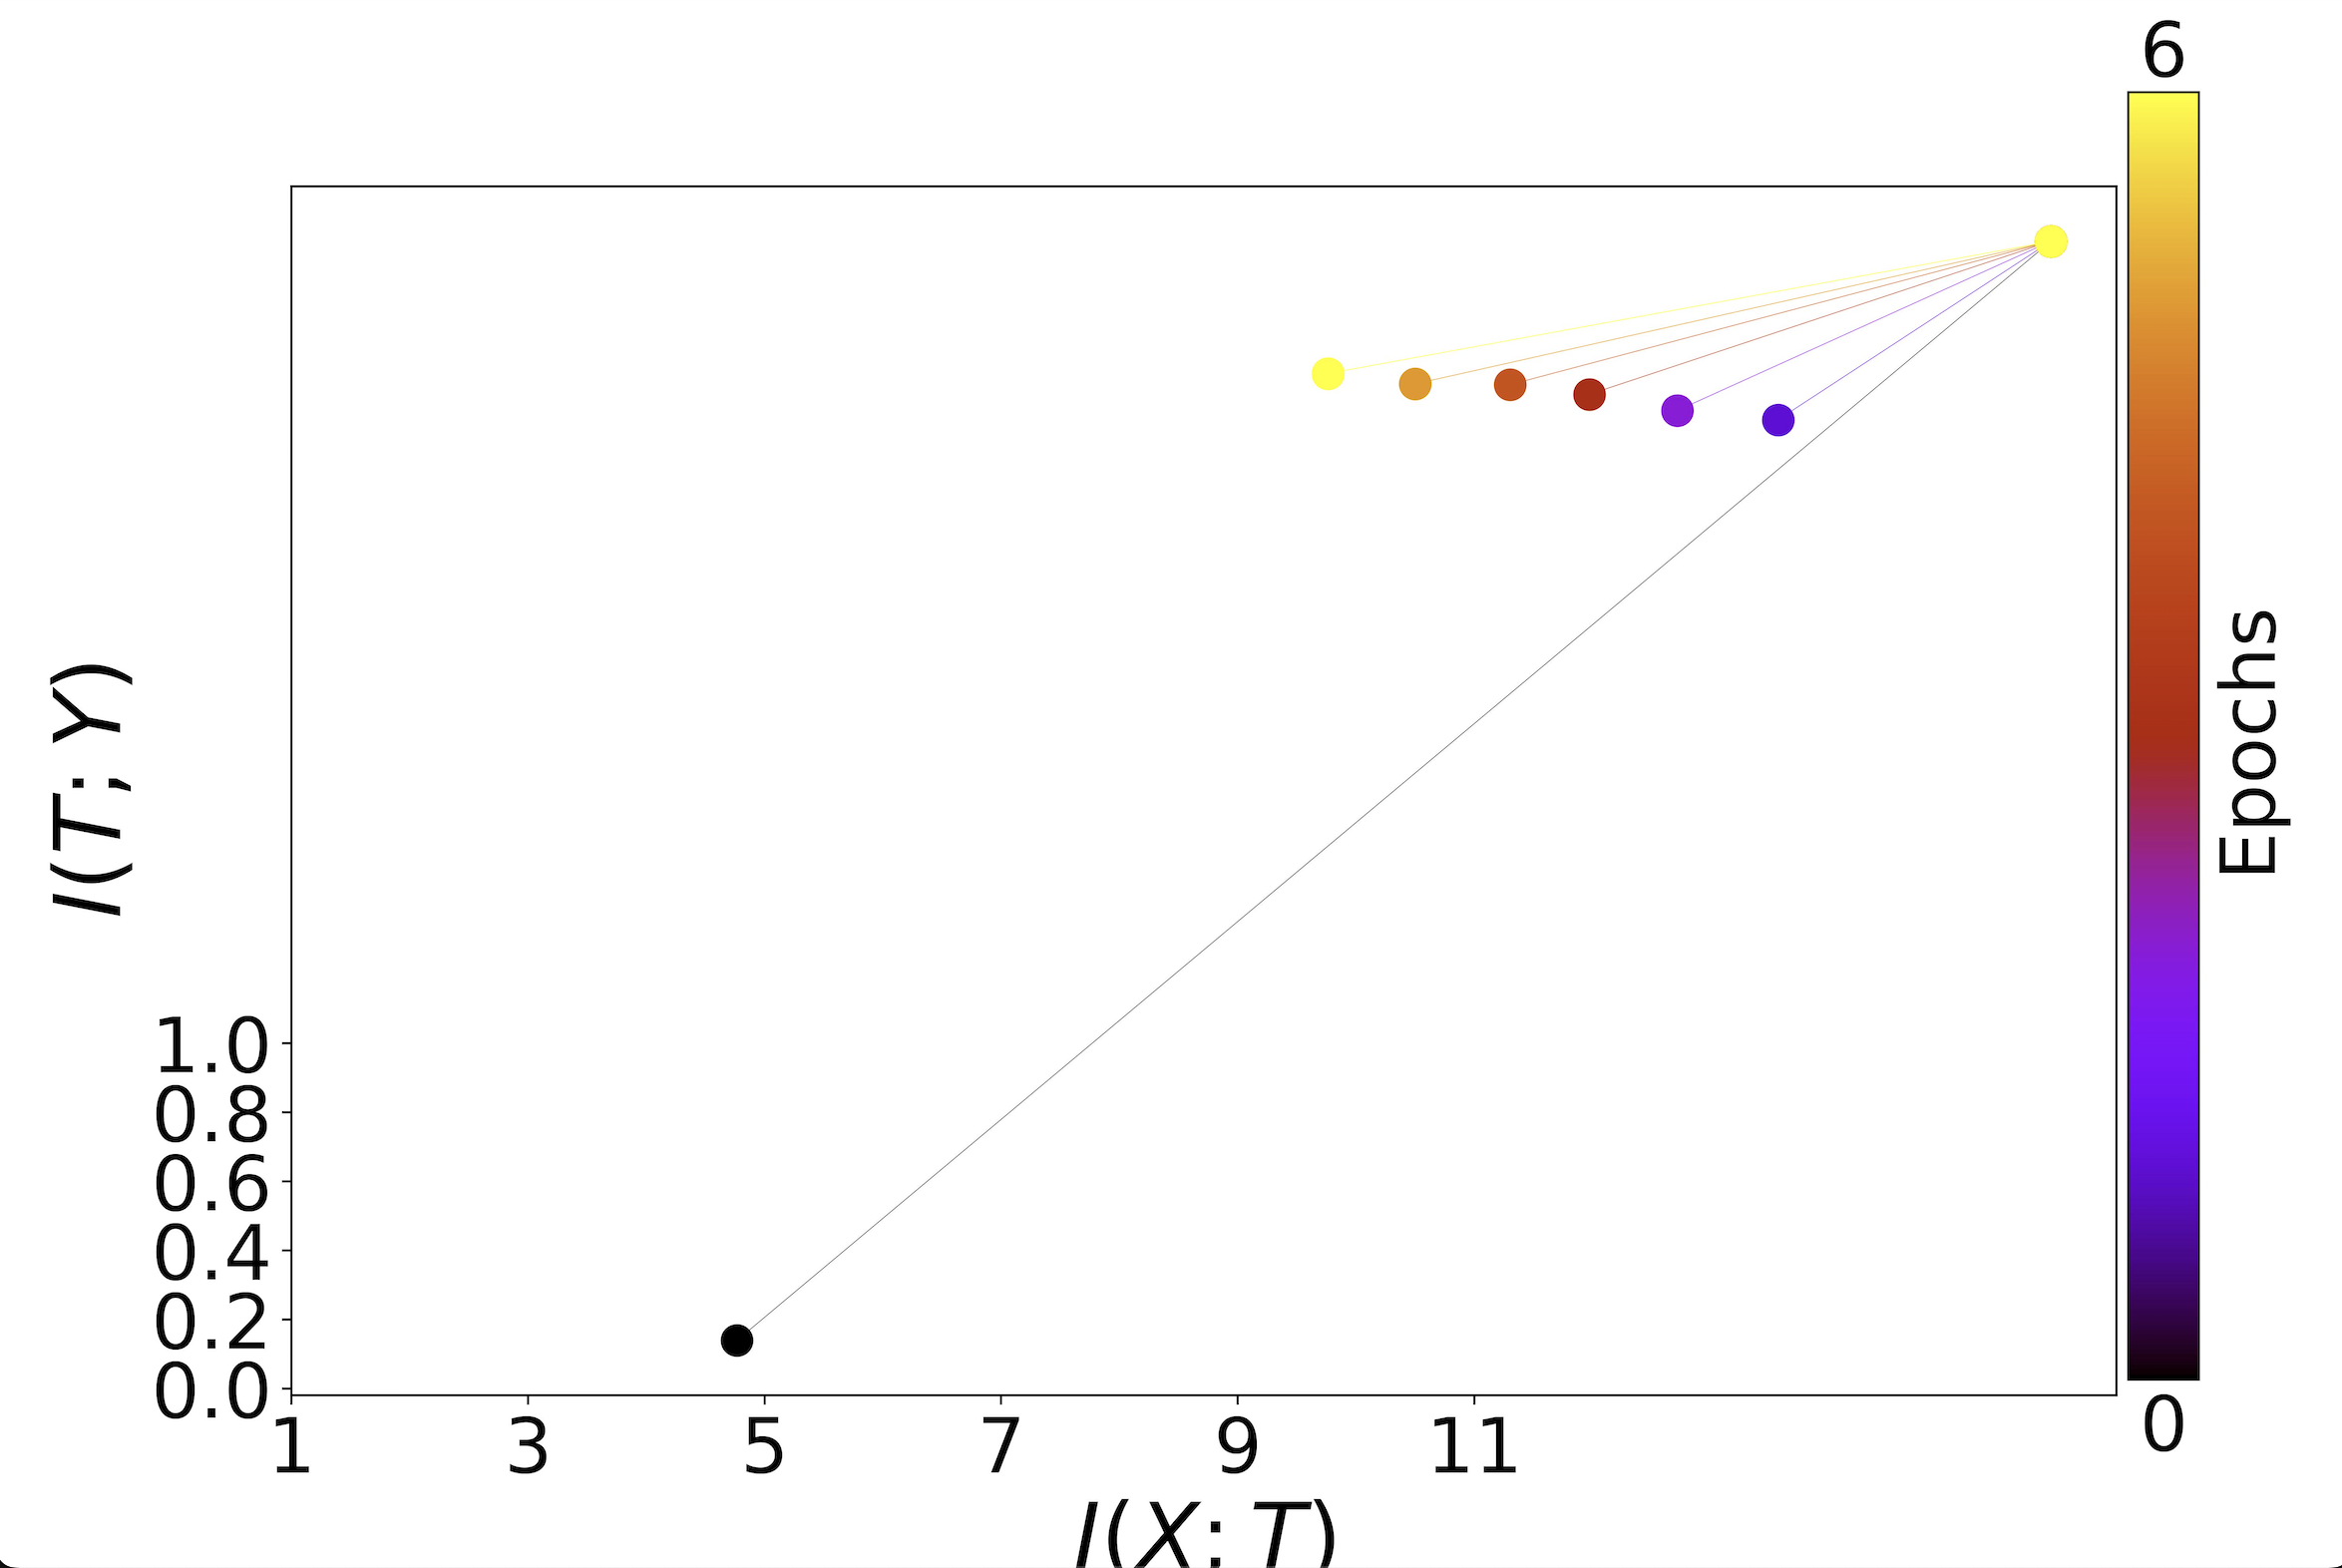

### Challenges

Some challenges I faced during this project include the following:\

- My system has a RAM of 8GB and thats why I wasn't able to run the network for more than 7 epochs without the system crashing.

- The information that was calculated was stored in memory. This led to the depletion of memory as the pickle file that was generated was very substanital in size. The plot function then tries to load the pickle.data file back onto memory which was unable to be fixed.

- I also attempted to run it in Google Colab. Google Colab provided me with 85 GB of RAM and GPU RAM but even that was unable to process the network for more than 7 epochs without crashing.

- The codebase was extremely bug ridden and poorly documented. The modification of the codebase to work for the a newer version of Tensorflow without proper documentaion was tedious. Also, working with CIFAR10 produced a whole array of new errors that needed to be manually fixed. 

- Due to all of these constraints, I unfortunately was unable to figure out how to plot the gradients for the network. 